#### iris 데이터셋 활용 꽃잎 너비 예측 모델  --- 선형회귀, 신경망 아님
- 데이터셋 : iris.csv에서 3개 Feature  사용
- 구현 프레임워크 : Pytorch _ torchmetrics 모듈 사용해서 성능지표 확인

[1] 모듈 로딩 및 데이터 준비

In [1]:
# 모듈 로딩 
import torch                        # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn               # 인공신경망 관련 모듈
import torch.nn.functional as F     # 손실, 거리 등 함수 관련 모듈
import torch.optim as optimizer     # 최적화 기법 관련 모듈

import pandas as pd                 # 데이터 파일 분석 관련 모듈
from sklearn.model_selection import train_test_split
from torchmetrics.regression import R2Score  # 성능 지표 관련 모듈 - 추가 설치

from torchinfo import summary       # 모델 정보 관련 모듈 - 추가 설치

In [2]:
# 모델의 가중치 및 절편 값 고정 설정
torch.manual_seed(1)

# 저장 및 실행 위치 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE => {DEVICE}')

DEVICE => cpu


In [3]:
# 데이터 로딩 : CSV ==> DataFrame
DATA_FILE = '../data/iris.csv'
irisDF = pd. read_csv(DATA_FILE, usecols=[0,1,2,3])
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


[2] 모델 준비
- 학습방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 >> 선형모델 ==> nn.Linear

In [4]:
# 모델 설계
# 입력층에 입력값 => sepal.length sepal.width petal.length 3개
# 출력층에 출력값 => petal.width 1개
# 입력층 - 입력 피쳐 : 3개,           출력 입력층에 존재하는 퍼셉트론 개수 :10개,   AF ReLU # >> ReLU : 0보다 작은애들은 0 나머지 양수는 자기의값을 준다
#                 ______________________|
#     AF :       |   ReLU                                
#                V
# 은닉층 - 입력 10개,                 출력 은닉층에 존재하는 퍼셉트론 개수 : 5개,   AF ReLU
#                 ______________________|
#     AF :       |    ReLU                              
#                V
# 출력층 - 입력 5개 ,                 출력 출력층에 존재하는 퍼셉트론 개수 :1개(출력),     AF- None
# 
# 
#                                                                          출력에서는 분류일때는 시그모이드
# 총 3개의 층을 만들거임                                                      #            다중일땐 소프트맥서 
                                                                            #            ReLU

model = nn.Sequential(nn.Linear(3,10),
                         nn.ReLU(),
                         nn.Linear(10,5),
                         nn.ReLU(),
                         nn.Linear(5,1)) # 입력층의 입력은 피쳐의 수, 출력의 출력은 타겟의 수, 나머지값의 개발자 마음대로 

In [5]:
# 구조 확인
print(model)              # (피쳐수, )      
summary(model, input_size=(3,)) # 왜 40개냐 >> (w1, w2, w3, b(절편)까지 있다) * 내가 설정한 입력층 퍼셉트론 개수 10개 >> 40개
                                # 그럼 은닉층은 >>> 은닉충도 입력층에서 받는 10가지 + 절편 >> 11개 * 내가 설정한 은닉층 퍼셉트론 개수 5개 >> 55개
                                # 이제 출력층은 >>> 은닉충도 입력층에서 받는 5가지 + 절편 >> 11개 * 출력 1개 >> 6개

                            ## So >>>> 퍼셉트론 => 내가 조정하는 하이퍼 파라미터 
                            #### 그래서 층이 많은게 성능이 좋냐?? 퍼셉트론이 많은게 좋냐??  >> 지금 현재 나온걸로는 '층'이 많은것이 성능이 좋다


# 여기서 퍼셉트론 하나의 일을 봤을땐
# (SL SW PL) * (w1 w2 w3) + b 가 하나의 퍼셉트론에 들어가 AF(activation function)
#                                               '한가지 값'을 출력되어져 나와 그다음 층으로 향한다.
#                                                   >>> 퍼셉트론 한개당 하나의 결과값을 낸다.

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1]                       --
├─Linear: 1-1                            [10]                      40
├─ReLU: 1-2                              [10]                      --
├─Linear: 1-3                            [5]                       55
├─ReLU: 1-4                              [5]                       --
├─Linear: 1-5                            [1]                       6
Total params: 101
Trainable params: 101
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [6]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}, {param}]\n')

[0.weight, Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119],
        [ 0.2710, -0.5435,  0.3462],
        [-0.1188,  0.2937,  0.0803],
        [-0.0707,  0.1601,  0.0285],
        [ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023],
        [ 0.5047,  0.1797, -0.2150],
        [-0.3487, -0.0968, -0.2490],
        [-0.1850,  0.0276,  0.3442],
        [ 0.3138, -0.5644,  0.3579]], requires_grad=True)]

[0.bias, Parameter containing:
tensor([ 0.1613,  0.5476,  0.3811, -0.5260, -0.5489, -0.2785,  0.5070, -0.0962,
         0.2471, -0.2683], requires_grad=True)]

[2.weight, Parameter containing:
tensor([[ 0.3103, -0.1338,  0.2371,  0.0037, -0.1666,  0.1625, -0.1679,  0.0930,
         -0.0913, -0.0347],
        [-0.3040, -0.1508,  0.1716, -0.0769,  0.3150,  0.2535, -0.0148, -0.2111,
          0.1926,  0.0981],
        [-0.2044,  0.2054,  0.1920,  0.2805, -0.1773, -0.0521, -0.0061,  0.0462,
         -0.2400, -0.2244],
        [ 0.1720, -0.0742,  0.1545,  0.0180,  0.1038, 

[3] 최적화 인스턴스 준비

In [7]:
# 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim = optimizer.Adam(model.parameters(), lr=0.1)

[4] 학습 ==> 개발자가 구현

-[4-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행 하거나 또는 학습 전 진행

In [8]:
# 피쳐와 타겟 분리
featureDF = irisDF[irisDF.columns[:-1]]
targetDF = irisDF[['petal.width']]

print(featureDF.shape, targetDF.shape)

(150, 3) (150, 1)


In [9]:
# Train & test
X_train, X_test, y_train, y_test = train_test_split(featureDF,
                                                    targetDF,
                                                    test_size=0.2,
                                                    random_state=5)

# Train & val
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.2,
                                                    random_state=5)

print(f'[feature] Train{X_train.shape}, Test{X_test.shape}, Val{X_val.shape}')
print(f'[target] Train{y_train.shape}, Test{y_test.shape}, Val{y_val.shape}')

[feature] Train(96, 3), Test(30, 3), Val(24, 3)
[target] Train(96, 1), Test(30, 1), Val(24, 1)


[4-2] 학습진행 : 진행전    
- 학습횟수 결정 => 에포크 설정   
- 배치크기 결정     
- 배치개수 계산

In [10]:
EPOCH = 100                               # 처음 ~ 끝까지 공부하는 회수   
BATCH_SIZE = 12                             # 한 에포크에서 한 번 학습할 분량 크기
BATCH_CNT = X_train.shape[0]//BATCH_SIZE    # 한 에포크에서 총 학습 횟수이면서 가중치 업데이트 횟수

print(f'EPOCH: {EPOCH}, BATCH_SIZE: {BATCH_SIZE}, BATCH_CNT: {BATCH_CNT}')

EPOCH: 100, BATCH_SIZE: 12, BATCH_CNT: 8


In [11]:
## 테스트/검증 함수 
# ==> 가중치, 절편 업데이트X, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행

# 모델 검증 및 테스트 
def testing(testDF,targetDF, kind="Val"):

    # Tensor화
    testTS = torch.FloatTensor(testDF.values).to(DEVICE) # GPU에 있으면 GPU에 돌려라
    targetTS = torch.FloatTensor(targetDF.values).to(DEVICE)

    with torch.no_grad(): # 가중치 및 절편 업데이트 진행X

        # 1. 학습진행 - forward
        pre_y = model(testTS)

        # 2. 오차계산 - 손실함수
        loss = F.mse_loss(pre_y, targetTS) 

        # 3. 성능 평가- R2
        r2 = R2Score()(pre_y, targetTS)

        # 4. 학습결과 출력 및 저장
        # print(f'[ {kind} ] LOSS : {loss}, R2 : {r2}')

    return loss, r2

In [12]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS):
    # [[],[]] <== [[train,val]
    loss_history= [[],[]]
    r2_history= [[],[]]

    for epoch in range(EPOCH):
        # 배치 손실 저장 변수
        bs_loss, bs_r2 = 0, 0

        # 배치크기 만큼 학습진행
        for i in range(BATCH_CNT):
            start = i*BATCH_SIZE
            end = start + BATCH_SIZE
            print(start, end)

            # BS크기만큼만 데이터 추출해서 Tensor화 진행
            BSX_train = torch.FloatTensor(X_train[start:end].values).to(DEVICE) # GPU에 있으면 GPU에 돌려라
            BSy_train = torch.FloatTensor(y_train[start:end].values).to(DEVICE)

            # print(BSX_train.shape, BSX_train.device, BSX_train.dtype) 
            # print(BSy_train.shape, BSy_train.device, BSy_train.dtype) 


            # 1. 학습진행 - forward
            pre_y = model(BSX_train)
            # print(f'{pre_y.shape}')

            # 2. 오차계산 - 손실함수 >>>> 평균이요??? 한해포크 배치??
            bs_loss = F.mse_loss(pre_y, BSy_train)
            bs_loss += bs_loss
            bs_r2 += R2Score()(pre_y,BSy_train).item()

            # 3. 최적화 - 가중치, 절편 업데이트 backward
            adam_optim.zero_grad() 
            bs_loss.backward()
            adam_optim.step()

        # 4. 검증 - 모델이 제대로 만들어지는지 검사용
        val_loss, val_r2 = testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())
        r2_history[1].append(val_r2.item())

        # 한 에포크 단위 손실과 성능지표
        loss_history[0].append(bs_loss.item()/BATCH_CNT)
        r2_history[0].append(bs_r2/BATCH_CNT)

        # 4. 학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}]\n - Train LOSS : {loss_history[0][-1]}, R2:{r2_history[0][-1]}')
        print(f'- Valid Loss : {loss_history[1][-1]}, R2:{r2_history[1][-1]}')
        
    return loss_history, r2_history

In [13]:
# 모델 학습 진행
loss, r2 = training(X_train, y_train, X_val, y_val)

0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
[0/100]
 - Train LOSS : 0.08585696667432785, R2:-0.5297544598579407
- Valid Loss : 0.4191381633281708, R2:-0.004299283027648926
0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
[1/100]
 - Train LOSS : 0.11584797501564026, R2:-0.10939279198646545
- Valid Loss : 0.49096497893333435, R2:-0.17640399932861328
0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
[2/100]
 - Train LOSS : 0.10361623764038086, R2:-0.1355888992547989
- Valid Loss : 0.44149693846702576, R2:-0.05787336826324463
0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
[3/100]
 - Train LOSS : 0.0956132635474205, R2:-0.018212810158729553
- Valid Loss : 0.3640402853488922, R2:0.12772095203399658
0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
[4/100]
 - Train LOSS : 0.03987951949238777, R2:0.24172329902648926
- Valid Loss : 0.26617905497550964, R2:0.3622068762779236
0 12
12 24
24 36
36 48
48 60
60 72
72 84
84 96
[5/100]
 - Train LOSS : 0.007886574603617191, R2:0.6738909855484962
- Valid Loss

In [14]:
loss

[[0.08585696667432785,
  0.11584797501564026,
  0.10361623764038086,
  0.0956132635474205,
  0.03987951949238777,
  0.007886574603617191,
  0.016923710703849792,
  0.016525743529200554,
  0.007573561742901802,
  0.004622735548764467,
  0.004646067041903734,
  0.004757831338793039,
  0.004879978951066732,
  0.005016160197556019,
  0.005107219330966473,
  0.005136497784405947,
  0.005053308326750994,
  0.00503171980381012,
  0.005152963567525148,
  0.005279799457639456,
  0.005320315714925528,
  0.00537143973633647,
  0.005452979821711779,
  0.005513396579772234,
  0.005584462080150843,
  0.005667971912771463,
  0.0057414802722632885,
  0.005825243890285492,
  0.005910839885473251,
  0.005999786779284477,
  0.006094054784625769,
  0.006189043167978525,
  0.006288654636591673,
  0.0063885594718158245,
  0.00646554259583354,
  0.006448159459978342,
  0.00630136439576745,
  0.006581932306289673,
  0.006523072253912687,
  0.006828260142356157,
  0.006645815912634134,
  0.007000081241130829,


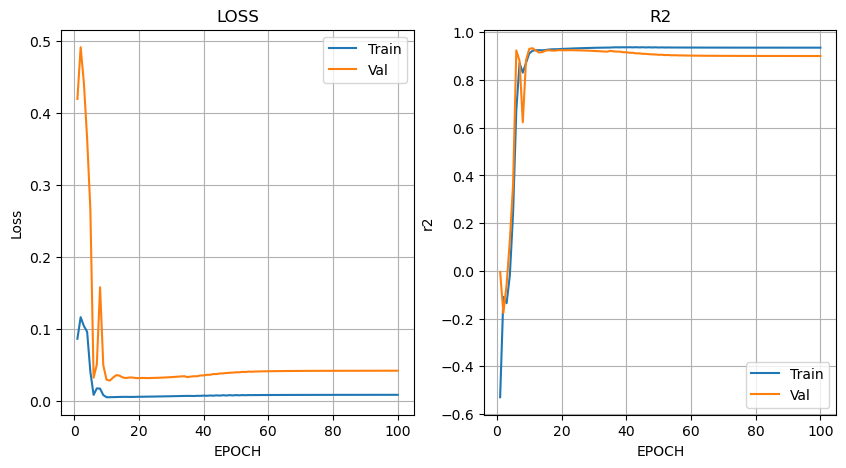

In [15]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

THRESHOLD=100 # 이걸로 EPOCH의 수가 많아도 뽑고싶은 범위를 정해서 그래프로 낸다다   
fg, axes= plt.subplots(1,2, figsize = (10,5))
axes[0].plot(range(1,THRESHOLD+1), loss[0][:THRESHOLD], label='Train')
axes[0].plot(range(1,THRESHOLD+1), loss[1][:THRESHOLD], label='Val')
axes[0].set_title('LOSS')
axes[0].set_xlabel('EPOCH')
axes[0].set_ylabel('Loss')
axes[0].grid()
axes[0].legend()


axes[1].plot(range(1,THRESHOLD+1), r2[0][:THRESHOLD], label='Train')
axes[1].plot(range(1,THRESHOLD+1), r2[1][:THRESHOLD], label='Val')
axes[1].set_title('R2')
axes[1].set_xlabel('EPOCH')
axes[1].set_ylabel('r2')
axes[1].grid()
axes[1].legend()

plt.show()